In [2]:
from scipy.spatial import distance
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

# DBSCAN From Scratch (Almost)

In the notebook below I will be creating a basic implementation of the seminal\
"DBSCAN" data clustering algorithm, as proposed by [Ester et al.](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

I am using the scipy.spatial.distance submodule to conveniently handle distance calculations, but otherwise I am relying on pure python within the algorithm.

## Density-Based Spatial Clustering of Applications with Noise

Given a set of points $P$, the radius of a neighborhood $\epsilon$, and a minimum number of points $minPts$:

1) Find all points within the $\epsilon$ neighborhood of each point\
2) Identify "core points" with at least $minPts$ neighbors\
3) Find "connected components" of all core points, ignoring non-core points; This densely connected grouping of core points is a cluster\
4) Assign each non-core point to a nearby cluster if a point within that cluster is $\epsilon$ reachable ("density-reachable"), otherwise point is noise

Any given point may initially considered noise and later revised to belong to a cluster, but once assigned to a cluster a point will never be reassigned.

Two points are considered "connected components, or are "density-connected," if they are $\epsilon$ reachable from a third point.

All core points within a cluster are connected components.

# Implementation

## Class Definition

In [3]:
class Basic_DBSCAN:
    """
    Parameters:
    
    eps: Radius of neighborhood graph
    
    minPts: Number of neighbors required to label a given point as a core point.
    
    metric: Distance metric used to determine distance between points; 
            currently accepts scipy.spatial.distance metrics for two numeric vectors
    
    """
    
    def __init__(self, eps, minPts, metric=distance.euclidean):
        self.eps = eps
        self.minPts = minPts
        self.metric = metric
    
    def fit_predict(self, X):
        """
        Parameters:
        
        X: An n-dimensional array of numeric vectors to be analyzed
        
        Returns:
        
        [n] cluster labels
        """
    
        clusters = [0] * X.shape[0]
        
        simple_DBSCAN(X, clusters, self.eps, self.minPts, self.metric)
        
        return clusters

## Functions

In [4]:
def simple_DBSCAN(X, clusters, eps, minPts, metric=distance.euclidean):
    """
    Driver; 
    iterates through neighborsGen for every point in X
    expands cluster for every point not determined to be noise
    """
    current = 0
    
    for i in range(0, X.shape[0]):
        if clusters[i] is not 0:
            continue
    
        neighbors = neighborsGen(X, i, eps, metric)

        if len(neighbors) < minPts:
            clusters[i] = -1

        else:
            current += 1
            expand(X, clusters, i, neighbors, current, eps, minPts, metric)
    
    return clusters

In [5]:
def neighborsGen(X, point, eps, metric):
    """
    Generates neighborhood graph for a given point
    """
    
    neighbors = []
    
    for i in range(X.shape[0]):
        if metric(X[point], X[i]) < eps:
            neighbors.append(i)
    
    return neighbors

In [6]:
def expand(X, clusters, point, neighbors, current, eps, minPts, metric):
    """
    Expands cluster from a given point until neighborhood boundaries are reached
    """
    clusters[point] = current
    
    i = 0
    while i < len(neighbors):
        
        nextPoint = neighbors[i]
        
        if clusters[nextPoint] == -1:
            clusters[nextPoint] = current
        
        elif clusters[nextPoint] == 0:
            clusters[nextPoint] = current
            
            nextNeighbors = neighborsGen(X, nextPoint, eps, metric)
            
            if len(nextNeighbors) >= minPts:
                neighbors = neighbors + nextNeighbors
        
        i += 1

In [7]:
def checkEqual(l1, l2):
    """
    Helper to illustrate accuracy of results
    """
    return len(l1) == len(l2) and sorted(l1) == sorted(l2)

# Results

## Loading Data

For this test, I'm using a subset of a dataset sourced from Kaggle.\
It contains minute-level weather data as reported by a weather station in San Diego, CA over a period of three years.

In [8]:
df = pd.read_csv('minute_weather_reduced.csv') # ~10% of the original dataset
df = df.dropna() # dropping entries with missing values
df = df.head(1000) # taking the first 1000 entries; ~10% of the ~10%
df = df.drop(columns=['Unnamed: 0', 'rowID', 'hpwren_timestamp', 'rain_accumulation', 'rain_duration']) # dropping unwanted columns
cols = df.columns

## Instantiating Class

In [10]:
scanner = Basic_DBSCAN(eps=0.3, minPts=30)

## Pairwise Clustering

### Comparison of clustering pairs of features across the dataset

Results are same as sk-learn: True


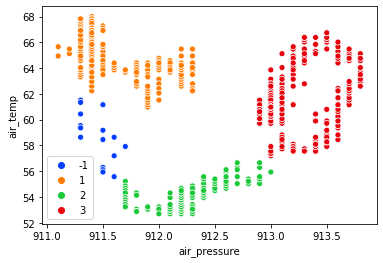

Results are same as sk-learn: True


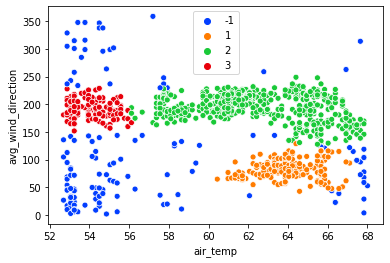

Results are same as sk-learn: True


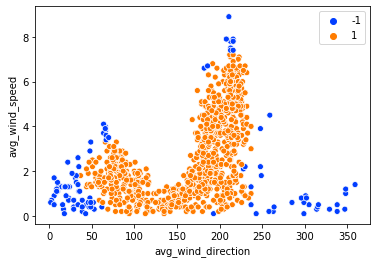

Results are same as sk-learn: True


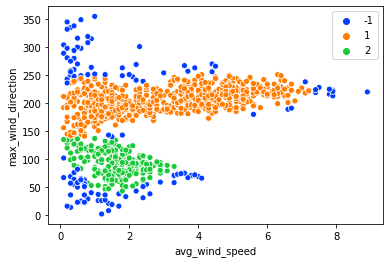

Results are same as sk-learn: True


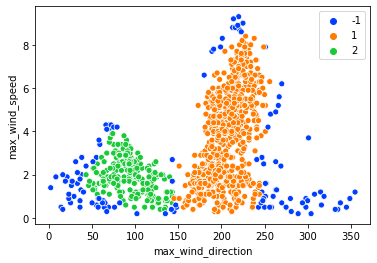

Results are same as sk-learn: True


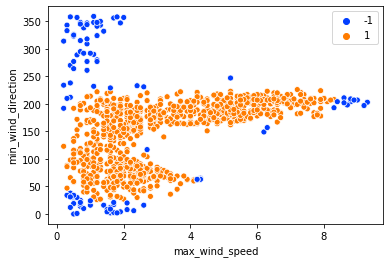

Results are same as sk-learn: True


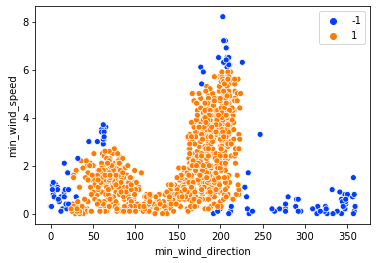

Results are same as sk-learn: True


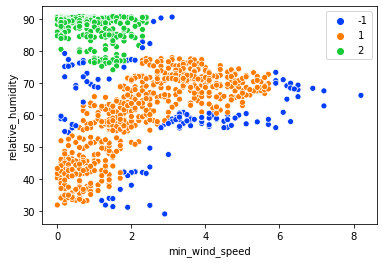

In [62]:
for x in range(len(cols)-1):
    
    X = df[[cols[x], cols[x+1]]]
    X = StandardScaler().fit_transform(X)
    
    clusters = scanner.fit_predict(X)
    
    sk_clusters = DBSCAN(eps=0.3, min_samples=30, metric=distance.euclidean).fit(X).labels_
    # sk-learn returns first cluster as 0; incrementing sk-learn clusters for comparison with my own
    sk_clusters = [x+1
               if x != -1
               else x
               for x in sk_clusters]
    
    print(f'Results are same as sk-learn: {checkEqual(clusters, sk_clusters)}')
    
    sns.scatterplot(df.iloc[:, x], df.iloc[:, x+1], 
                    hue=clusters, palette='bright')
    plt.show();

### Visual Confirmation: Comparison of Plotted Clusters

Results are same as sk-learn: True


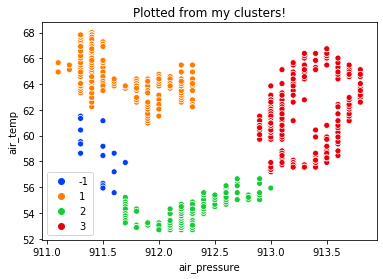

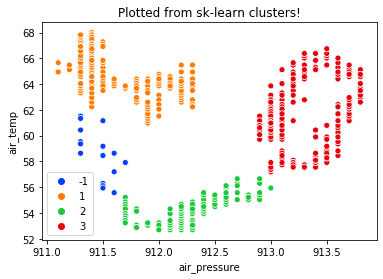

In [12]:
X = df[[cols[0], cols[1]]]
X = StandardScaler().fit_transform(X)

clusters = scanner.fit_predict(X)

sk_clusters = DBSCAN(eps=0.3, min_samples=30, metric=distance.euclidean).fit(X).labels_
sk_clusters = [x+1
               if x != -1
               else x
               for x in sk_clusters]

print(f'Results are same as sk-learn: {checkEqual(clusters, sk_clusters)}')

# my clusters
sns.scatterplot(df.iloc[:, 0], df.iloc[:, 1], 
                hue=clusters, palette='bright')
plt.title('Plotted from my clusters!')
plt.show();

# sk-learn clusters
sns.scatterplot(df.iloc[:, 0], df.iloc[:, 1], 
                hue=sk_clusters, palette='bright')
plt.title('Plotted from sk-learn clusters!')
plt.show();

## Clustering Using Whole Dataset

DBSCAN can continue to be effective as the dimensionality of the data increases,\
particularly with the use of distance metrics better suited to high dimensionality,\
though at extremely high dimensions [alterations](https://ieeexplore.ieee.org/document/7823505) 
to [DBSCAN](https://arxiv.org/abs/1801.06965) have been [proposed](https://link.springer.com/chapter/10.1007/978-3-319-31750-2_20) to better combat instability and inefficiency.

Results are same as sk-learn: True


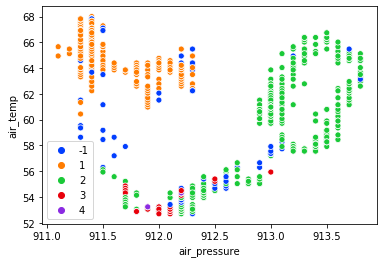

In [25]:
X = StandardScaler().fit_transform(df)

clusters = Basic_DBSCAN(eps=.85, minPts=7).fit_predict(X)
sk_clusters = DBSCAN(eps=.85, min_samples=7).fit(X)

sk_clusters = sk_clusters.labels_
sk_clusters = [x+1
               if x != -1
               else x
               for x in sk_clusters]

print(f'Results are same as sk-learn: {checkEqual(clusters, sk_clusters)}')

sns.scatterplot(df.iloc[:, 0], df.iloc[:, 1], 
                hue=clusters, palette='bright')

plt.show();

### TSNE for Visualization

In [57]:
tsne = TSNE(n_components=2, perplexity=50, n_jobs=-2, n_iter=5000, random_state=42)

tsne_components = tsne.fit_transform(X)

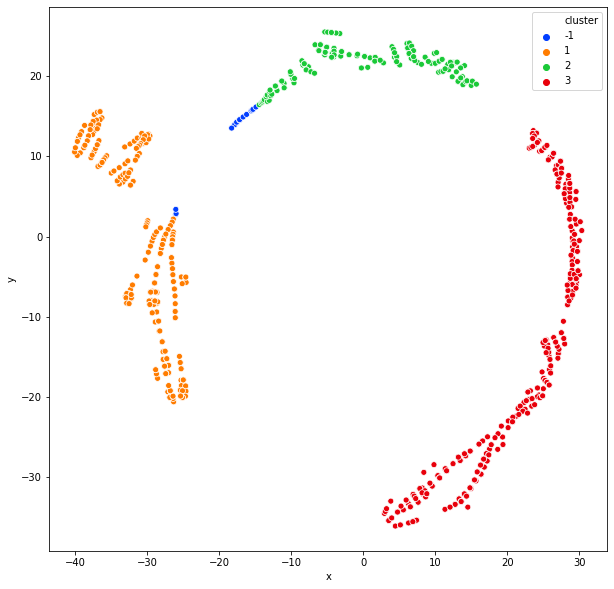

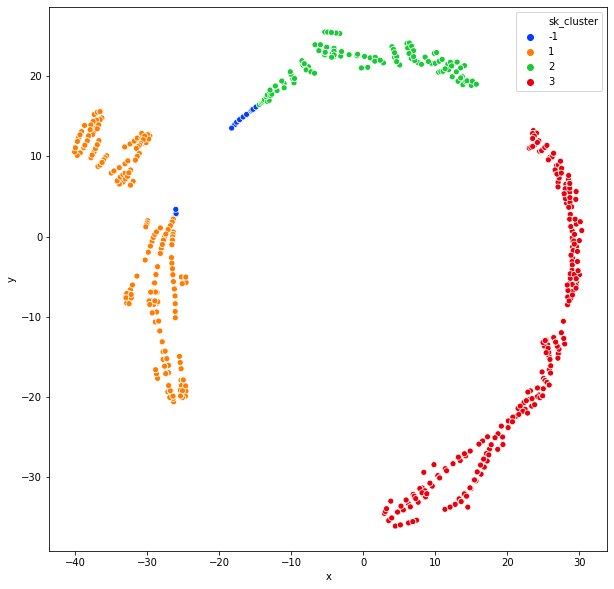

In [58]:
ts = pd.DataFrame(tsne_components)
ts['cluster'] = clusters
ts['sk_cluster'] = sk_clusters
ts.columns = ['x', 'y', 'cluster', 'sk_cluster']

# my clusters

plt.figure(figsize=(10,10))

sns.scatterplot(data=ts, x='x', y='y', 
                hue='cluster', legend='full', palette='bright')

plt.show();

# sklearn clusters

plt.figure(figsize=(10,10))

sns.scatterplot(data=ts, x='x', y='y', 
                hue='sk_cluster', legend='full', palette='bright')

plt.show();